In [1]:
import os
import pydub
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy import signal
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, TimeDistributed, GRU, Conv1D, Dropout, BatchNormalization
from tensorflow.keras import Model

c:\Users\s9554\miniconda3\envs\main_ml\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
DIR = r"D:\Kaggle\trigger_word_detection\raw_data"

C:\Users\s9554\AppData\Local\Temp\ipykernel_18104\3048827253.py:3: UserWarning: nperseg = 256 is greater than input length  = 2, using nperseg = 2
  frequency, time, spectogram = signal.spectrogram(samples, sample_rate)


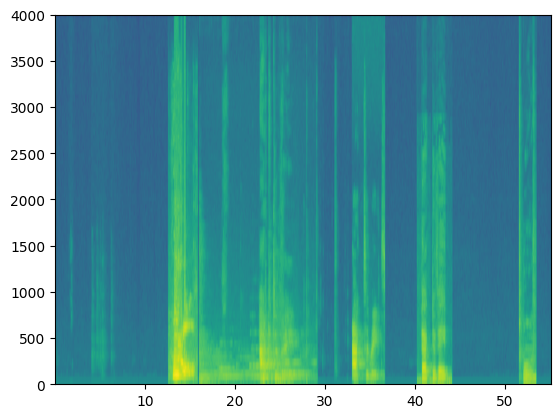

In [20]:
sample_rate, samples = wavfile.read(r"D:\Kaggle\trigger_word_detection\raw_data\backgrounds\1.wav")
_, data = wavfile.read(r'train.wav')
frequency, time, spectogram = signal.spectrogram(samples, sample_rate)
x = graph_spectrogram(r'train.wav')

In [21]:
# print(f"samples: {samples}")
print(f"sample_rate: {sample_rate}")
print(f"frequency: {frequency}")
print(f"time: {time}")
print(spectogram.shape)
print(f"plt_spectrogram: {x.shape}")
# plt.pcolormesh(time, frequency, spectogram)
# plt.imshow(spectogram)

sample_rate: 44100
frequency: [    0. 22050.]
time: [2.2675737e-05]
(441000, 2, 1)
plt_spectrogram: (101, 5511)


In [3]:
def load_audio_file(DIR):
    pos = []
    neg = []
    back = []
    for i in os.listdir(DIR):
        d = os.path.join(DIR, i)
        for aud in os.listdir(d):
            audio_file = os.path.join(d, aud)
            if audio_file.endswith('wav'):
                audio = pydub.AudioSegment.from_wav(audio_file)
                if i == 'activates':
                    pos.append(audio)
                elif i == 'backgrounds':
                    back.append(audio)
                elif i == 'negatives':
                    neg.append(audio)

    return pos, neg, back

In [4]:
def get_random_time(segment_ms, background_len_ms):
    segment_start  = np.random.randint(low = 0, high = background_len_ms - segment_ms)
    segment_end = segment_start + segment_ms - 1

    return (segment_start, segment_end)

In [5]:
def is_overlapping(segment_time, previos_segment_time):
    segment_start, segment_end = segment_time
    overlap = False
    for prev_str, prev_end in previos_segment_time:
        if segment_start <= prev_end and segment_end >= prev_str:
            overlap = True
            break
    
    return overlap

In [6]:
def insert_audio_clip(background, audio_clip, previous_time):
    segment_ms = len(audio_clip)
    random_time = get_random_time(segment_ms, len(background))
    retry = 5

    while is_overlapping(random_time, previous_time) and retry >= 0:
        random_time = get_random_time(segment_ms, len(background))
        retry -= 1
    
    if not is_overlapping(random_time, previous_time):
        previous_time.append(random_time)
        new_background = background.overlay(audio_clip, position = random_time[0])

    else:
        new_background = background
        random_time = (len(background), len(background))

    return new_background, random_time

In [7]:
def insert_ones(y, segment_end_ms):
    _, ty = y.shape
    segment_end_y = int(segment_end_ms * ty / 10000.0)

    if segment_end_y < ty:
        for i in range(segment_end_y + 1, segment_end_y + 51):
            if i < ty:
                y[0, i] = 1

    return y

In [8]:
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

In [9]:
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

In [10]:
def create_training_ex(background, positive, negative, ty):
    background -= 20
    y = np.zeros((1, ty))
    previous_segment = []

    number_of_positives = np.random.randint(0, 5)
    random_indices = np.random.randint(len(positive), size=number_of_positives)
    random_positives = [positive[i] for i in random_indices]
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negative), size=number_of_negatives)
    random_negatives = [negative[i] for i in random_indices]
    print(f"no_of_psoitives: {number_of_positives}")
    print(f"random_psoitives: {random_positives}")
    print(f"no_of_negatives: {number_of_negatives}")
    print(f"random_negetives: {random_negatives}")

    for random_activate in random_positives:
        background, segment_time = insert_audio_clip(background, random_activate, previous_segment)
        segment_start, segment_end = segment_time
        y = insert_ones(y, segment_end)

    for random_neg in random_negatives:
        background, segment_time = insert_audio_clip(background, random_neg, previous_segment)

    background = background.apply_gain(-20 -background.dBFS)

    file_handle = background.export("train" + ".wav", format="wav")

    x = graph_spectrogram("train.wav")
    
    return x, y
        

In [11]:
positive, negative, backgrounds = load_audio_file(DIR)
Ty = 1375

no_of_psoitives: 3
random_psoitives: [<pydub.audio_segment.AudioSegment object at 0x000001BB0EB3FFD0>, <pydub.audio_segment.AudioSegment object at 0x000001BB449FFA30>, <pydub.audio_segment.AudioSegment object at 0x000001BB0EB27EB0>]
no_of_negatives: 1
random_negetives: [<pydub.audio_segment.AudioSegment object at 0x000001BB0EB3FB50>]


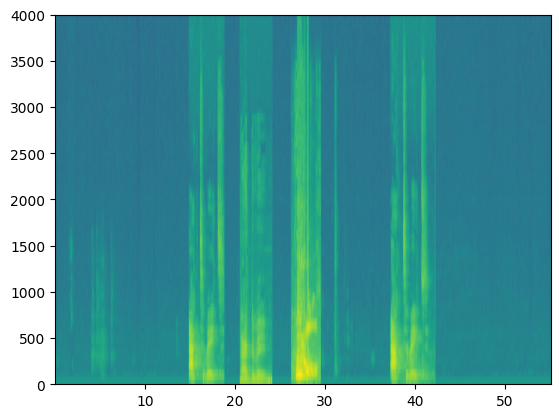

In [12]:
x, y = create_training_ex(backgrounds[0], positive, negative, Ty)

In [13]:
def create_dataset():
    X, Y = [], []
    batch_samples = 32
    for i in range(0, batch_samples):
        x, y = create_training_ex(backgrounds[i % 2], positive, negative, Ty)
        X.append(x.swapaxes(0, 1))
        Y.append(y.swapaxes(0, 1))

    return np.array(X), np.array(Y)

no_of_psoitives: 4
random_psoitives: [<pydub.audio_segment.AudioSegment object at 0x000001BB0EB3F790>, <pydub.audio_segment.AudioSegment object at 0x000001BB499F7C70>, <pydub.audio_segment.AudioSegment object at 0x000001BB0EB3FFD0>, <pydub.audio_segment.AudioSegment object at 0x000001BB0EB3FFD0>]
no_of_negatives: 1
random_negetives: [<pydub.audio_segment.AudioSegment object at 0x000001BB0EB3F760>]
no_of_psoitives: 4
random_psoitives: [<pydub.audio_segment.AudioSegment object at 0x000001BB0EB3F700>, <pydub.audio_segment.AudioSegment object at 0x000001BB0EB3F4F0>, <pydub.audio_segment.AudioSegment object at 0x000001BB449FFA30>, <pydub.audio_segment.AudioSegment object at 0x000001BB0EB3F700>]
no_of_negatives: 2
random_negetives: [<pydub.audio_segment.AudioSegment object at 0x000001BB0EB3FB50>, <pydub.audio_segment.AudioSegment object at 0x000001BB0EB3FA30>]
no_of_psoitives: 1
random_psoitives: [<pydub.audio_segment.AudioSegment object at 0x000001BB0EB3FC40>]
no_of_negatives: 1
random_nege

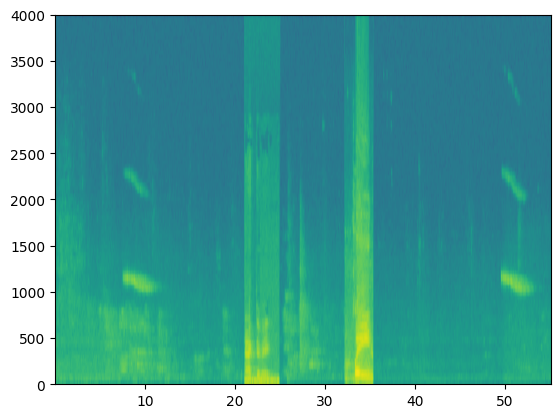

In [14]:
x, y = create_dataset()

In [15]:
print(x.shape)
print(y.shape)

(32, 5511, 101)
(32, 1375, 1)


In [16]:
def modelf(input_shape):
    X_input = tf.keras.Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    # Add a Conv1D with 196 units, kernel size of 15 and stride of 4
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    # Batch normalization
    X = BatchNormalization()(X)
    # ReLu activation
    X = Activation('relu')(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)                                  

    # Step 2: First GRU Layer (≈4 lines)
    # GRU (use 128 units and return the sequences)
    X = GRU(128, return_sequences=True)(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)
    # Batch normalization.
    X = BatchNormalization()(X)                           
    
    # Step 3: Second GRU Layer (≈4 lines)
    # GRU (use 128 units and return the sequences)
    X = GRU(128, return_sequences=True)(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)       
    # Batch normalization
    X = BatchNormalization()(X) 
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)
    X = TimeDistributed(Dense(1, activation='sigmoid'))(X)
    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [17]:
model = modelf((5511, 101))

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5511, 101)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1375, 196)      │       297,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1375, 196)      │           784 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1375, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1375, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1375, 128)      │       125,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1375, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 1375, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1375, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1375, 1)        │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,329 (2.00 MB)

 Trainable params: 522,425 (1.99 MB)

 Non-trainable params: 904 (3.53 KB)

In [19]:
model.layers[2].trainable = False
model.layers[7].trainable = False
model.layers[10].trainable = False

In [20]:
opt = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [21]:
model.fit(x, y, batch_size = 16, epochs=5)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 12s/step - accuracy: 0.5488 - loss: 1.1009
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 8s/step - accuracy: 0.7057 - loss: 0.9066
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 9s/step - accuracy: 0.7719 - loss: 0.7404
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.8203 - loss: 0.6058
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 16s/step - accuracy: 0.8526 - loss: 0.5155


In [22]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)
    
    # Correct the amplitude of the input file before prediction 
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, -20.0)
    file_handle = audio_clip.export("tmp.wav", format="wav")
    filename = "tmp.wav"

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [23]:
model.save(r'D:\Voice_recog\trigger detection\model\441khz.h5')